In [1]:
from jax.config import config
config.update("jax_enable_x64", True)

import jax.numpy as jnp
import numpy as onp
import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
from gen_elo.margin_functions import margin_functions

/anaconda2/envs/jax/lib/python3.7/site-packages/jax/lib/xla_bridge.py:119: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [3]:
from tdata.datasets.oncourt_dataset import OnCourtDataset

In [4]:
dataset = OnCourtDataset()

/anaconda2/envs/jax/lib/python3.7/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/anaconda2/envs/jax/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [5]:
df = dataset.get_stats_df()

In [6]:
to_use = df[df['year'] >= 2010]
to_use = to_use.dropna(subset=['W1S_1'])

spw_1 = (to_use['W1S_1'] + to_use['W2S_1']) / (to_use['W1SOF_1'] + to_use['W2SOF_1'])
spw_2 = (to_use['W1S_2'] + to_use['W2S_2']) / (to_use['W1SOF_2'] + to_use['W2SOF_2'])

margins = (spw_1 - spw_2).values

In [7]:
winners = to_use['winner'].values
losers = to_use['loser'].values
surface = to_use['surface'].values

In [8]:
from sklearn.preprocessing import LabelEncoder

In [9]:
surf_encoder = LabelEncoder()

In [10]:
surface_enc = surf_encoder.fit_transform(surface)

In [55]:
surf_encoder.classes_

array(['clay', 'grass', 'hard', 'indoor_hard'], dtype=object)

In [11]:
n_matches = winners.shape[0]

a_winner = onp.zeros((n_matches, len(surf_encoder.classes_)))
a_winner[onp.arange(n_matches), surface_enc] = 1
a_loser = a_winner.copy()

a_full = onp.concatenate([a_winner, -a_loser], axis=1)

In [12]:
a_full.shape

(26564, 8)

In [13]:
import numpy as onp

encoder = LabelEncoder()
encoder.fit(onp.concatenate([winners, losers]))

winners_array, losers_array = map(encoder.transform, [winners, losers])

In [14]:
from gen_elo.general import optimise_elo, EloParams

In [15]:
theta = {'factor': 0.1, 'obs_sd': 0.1, 'offset': 0.1}
theta = {x: jnp.array(y) for x, y in theta.items()}

start_params = EloParams(
    theta=theta,
    cov_mat=jnp.eye(len(surf_encoder.classes_))
)

In [16]:
y_full = margins.reshape(-1, 1)

In [17]:
final_params, success = optimise_elo(start_params, margin_functions, winners_array,
                      losers_array, a_full, y_full, n_players=len(encoder.classes_))

{'factor': 0.010000000000000002, 'obs_sd': 0.010000000000000002, 'offset': array(0.1)}
[[1.000001 0.       0.       0.      ]
 [0.       1.000001 0.       0.      ]
 [0.       0.       1.000001 0.      ]
 [0.       0.       0.       1.000001]]
{'factor': Traced<ShapedArray(float64[])>with<JVPTrace(level=1/1)>, 'obs_sd': Traced<ShapedArray(float64[])>with<JVPTrace(level=1/1)>, 'offset': Traced<ShapedArray(float64[])>with<JVPTrace(level=1/1)>}
Traced<ShapedArray(float64[4,4])>with<JVPTrace(level=1/1)>
{'factor': 0.6874998688878271, 'obs_sd': 0.6374541733134403, 'offset': array(0.08413736)}
[[1.02277311e+00 2.58949466e-05 2.38143129e-04 1.60550604e-04]
 [2.58949466e-05 1.00770339e+00 1.91278864e-04 5.09453699e-05]
 [2.38143129e-04 1.91278864e-04 1.03012864e+00 2.52329620e-04]
 [1.60550604e-04 5.09453699e-05 2.52329620e-04 1.01273894e+00]]
{'factor': 532.1235249553932, 'obs_sd': 694.701959275095, 'offset': array(-0.79762476)}
[[ 9.11404831e+01 -2.89909282e-02 -2.02455555e-01 -1.49551751e-0

{'factor': 1.0539515270273019, 'obs_sd': 0.43662658225535267, 'offset': array(0.06899791)}
[[ 2.11660501e-02 -2.66740370e-04  4.13966685e-03  5.78595710e-04]
 [-2.66740370e-04  4.45370054e-03 -2.48871117e-03  4.41373651e-04]
 [ 4.13966685e-03 -2.48871117e-03  3.19682213e-01  5.19445510e-04]
 [ 5.78595710e-04  4.41373651e-04  5.19445510e-04  2.48495499e-03]]
{'factor': 1.0467508731804205, 'obs_sd': 0.43603533757149554, 'offset': array(0.05802319)}
[[ 0.02487576 -0.00062267  0.00620406 -0.00131529]
 [-0.00062267  0.00600223 -0.00407187  0.00158459]
 [ 0.00620406 -0.00407187  0.18967199 -0.00288863]
 [-0.00131529  0.00158459 -0.00288863  0.0008564 ]]
{'factor': 1.0181950779427544, 'obs_sd': 0.4336743646292425, 'offset': array(0.01412433)}
[[ 0.04270864 -0.00256379  0.01712442 -0.0119048 ]
 [-0.00256379  0.01456002 -0.01387085  0.00952113]
 [ 0.01712442 -0.01387085  0.02835315 -0.01036437]
 [-0.0119048   0.00952113 -0.01036437  0.01932541]]
{'factor': 1.0311397280692378, 'obs_sd': 0.434747

{'factor': 1.9585311986911487, 'obs_sd': 0.04864848984088905, 'offset': array(-0.04564986)}
[[ 0.03753533  0.00507855  0.00155318  0.02509101]
 [ 0.00507855  0.01941011 -0.00053585 -0.00642491]
 [ 0.00155318 -0.00053585  0.00041477  0.00082566]
 [ 0.02509101 -0.00642491  0.00082566  0.02445394]]
{'factor': 1.8198799584095553, 'obs_sd': 0.07726375237736108, 'offset': array(0.1086306)}
[[ 1.71623045e-06  1.45210648e-05 -1.28959303e-05  3.08928483e-05]
 [ 1.45210648e-05  5.14660708e-04  6.31699196e-05  2.80719703e-04]
 [-1.28959303e-05  6.31699196e-05  1.24330443e-03 -9.86140021e-04]
 [ 3.08928483e-05  2.80719703e-04 -9.86140021e-04  2.04338219e-03]]
{'factor': 1.8138242790812538, 'obs_sd': 0.07875287283603163, 'offset': array(0.11119698)}
[[ 1.96778255e-04  1.15295515e-04 -1.98466186e-04  5.42233372e-04]
 [ 1.15295515e-04  1.41081634e-04  4.71285938e-05  1.25648863e-04]
 [-1.98466186e-04  4.71285938e-05  9.86326410e-04 -9.66251504e-04]
 [ 5.42233372e-04  1.25648863e-04 -9.66251504e-04  2

{'factor': 1.7734263474314127, 'obs_sd': 0.0877363476554642, 'offset': array(0.10284333)}
[[7.82866347e-05 3.15532209e-05 5.14291535e-05 2.96342681e-05]
 [3.15532209e-05 7.97383935e-05 5.00092459e-05 4.92772437e-05]
 [5.14291535e-05 5.00092459e-05 6.60399096e-05 5.38082403e-05]
 [2.96342681e-05 4.92772437e-05 5.38082403e-05 5.34926608e-05]]
{'factor': 1.7733697530865802, 'obs_sd': 0.08775103722748774, 'offset': array(0.10288717)}
[[7.73856238e-05 3.02283953e-05 5.06885179e-05 2.88601350e-05]
 [3.02283953e-05 7.79527878e-05 4.96477019e-05 4.97027746e-05]
 [5.06885179e-05 4.96477019e-05 6.55340377e-05 5.39740862e-05]
 [2.88601350e-05 4.97027746e-05 5.39740862e-05 5.36630992e-05]]
{'factor': 1.773257703102082, 'obs_sd': 0.08777946199578208, 'offset': array(0.10289073)}
[[7.82468871e-05 2.97798659e-05 5.09391554e-05 2.93670462e-05]
 [2.97798659e-05 7.55690640e-05 5.02473631e-05 4.96312757e-05]
 [5.09391554e-05 5.02473631e-05 6.54298640e-05 5.45820140e-05]
 [2.93670462e-05 4.96312757e-05 5.

{'factor': 1.7647081055171971, 'obs_sd': 0.08782614144236985, 'offset': array(0.10281715)}
[[7.81951898e-05 3.06451809e-05 5.21578865e-05 3.14101045e-05]
 [3.06451809e-05 7.67585471e-05 5.20022202e-05 5.17063910e-05]
 [5.21578865e-05 5.20022202e-05 6.61357386e-05 5.62383561e-05]
 [3.14101045e-05 5.17063910e-05 5.62383561e-05 5.50153173e-05]]
{'factor': 1.7584256521376003, 'obs_sd': 0.08782570749390702, 'offset': array(0.10281333)}
[[7.87467195e-05 3.08173183e-05 5.25253278e-05 3.16202303e-05]
 [3.08173183e-05 7.73308295e-05 5.23735645e-05 5.21062734e-05]
 [5.25253278e-05 5.23735645e-05 6.65859629e-05 5.65925260e-05]
 [3.16202303e-05 5.21062734e-05 5.65925260e-05 5.53277399e-05]]
{'factor': 1.7471001820341923, 'obs_sd': 0.08782515197788257, 'offset': array(0.10280819)}
[[7.97548968e-05 3.11510222e-05 5.31976600e-05 3.20087828e-05]
 [3.11510222e-05 7.83628849e-05 5.30507382e-05 5.28224401e-05]
 [5.31976600e-05 5.30507382e-05 6.74157040e-05 5.72596591e-05]
 [3.20087828e-05 5.28224401e-05 

{'factor': 0.7440261786240095, 'obs_sd': 0.08783109771643699, 'offset': array(0.10282407)}
[[0.00043832 0.0001694  0.0002927  0.00017454]
 [0.0001694  0.00043203 0.00029108 0.00029194]
 [0.0002927  0.00029108 0.00036913 0.00031517]
 [0.00017454 0.00029194 0.00031517 0.00030222]]
{'factor': 0.6863851741433149, 'obs_sd': 0.08782999998132023, 'offset': array(0.10282785)}
[[0.00051133 0.00019804 0.00034147 0.0002038 ]
 [0.00019804 0.00050363 0.00033943 0.0003399 ]
 [0.00034147 0.00033943 0.00043087 0.00036819]
 [0.0002038  0.0003399  0.00036819 0.00035284]]
{'factor': 0.6389952703019717, 'obs_sd': 0.08783176822230039, 'offset': array(0.10283121)}
[[0.00058677 0.00022908 0.00039203 0.00023444]
 [0.00022908 0.00057669 0.0003895  0.00038841]
 [0.00039203 0.0003895  0.00049526 0.00042425]
 [0.00023444 0.00038841 0.00042425 0.00040626]]
{'factor': 0.6216704140135177, 'obs_sd': 0.08783420403604383, 'offset': array(0.10283423)}
[[0.00062829 0.00024808 0.00042008 0.0002518 ]
 [0.00024808 0.0006157

{'factor': 0.1846912013296081, 'obs_sd': 0.0878319608527565, 'offset': array(0.10282238)}
[[0.00687259 0.00281023 0.00460878 0.00282298]
 [0.00281023 0.00665389 0.00456707 0.00442581]
 [0.00460878 0.00456707 0.0058745  0.00504624]
 [0.00282298 0.00442581 0.00504624 0.0047786 ]]
{'factor': 0.1801898412154005, 'obs_sd': 0.08783490235375481, 'offset': array(0.10282462)}
[[0.00735454 0.0030933  0.0049413  0.0030583 ]
 [0.0030933  0.00707702 0.00488481 0.00465267]
 [0.0049413  0.00488481 0.00633728 0.00548108]
 [0.0030583  0.00465267 0.00548108 0.00519155]]
{'factor': 0.17296114536188242, 'obs_sd': 0.08783349508806966, 'offset': array(0.10282698)}
[[0.00792918 0.00338605 0.00533288 0.00332054]
 [0.00338605 0.0076061  0.00526469 0.00496598]
 [0.00533288 0.00526469 0.00686458 0.00595942]
 [0.00332054 0.00496598 0.00595942 0.0056498 ]]
{'factor': 0.16527041492968889, 'obs_sd': 0.08783117910727146, 'offset': array(0.10283016)}
[[0.00866385 0.00375427 0.00583285 0.00365339]
 [0.00375427 0.008287

{'factor': 0.009527961356256068, 'obs_sd': 0.08782012564957957, 'offset': array(0.10250023)}
[[2.44959643 0.61428325 1.60196767 0.85964029]
 [0.61428325 2.72809834 1.63319111 1.93767382]
 [1.60196767 1.63319111 1.9345465  1.56738767]
 [0.85964029 1.93767382 1.56738767 2.22535614]]
{'factor': 0.0034602494620099068, 'obs_sd': 0.087839177659427, 'offset': array(0.10236472)}
[[5.88170631 1.39866506 3.8385185  2.03252305]
 [1.39866506 6.63677241 3.93269383 4.75090219]
 [3.8385185  3.93269383 4.62249488 3.74375373]
 [2.03252305 4.75090219 3.74375373 5.52047201]]
{'factor': 0.008068939965169785, 'obs_sd': 0.08782394891216735, 'offset': array(0.10247304)}
[[3.01969716 0.74627751 1.97365402 1.05516949]
 [0.74627751 3.37526744 2.01486078 2.40264278]
 [1.97365402 2.01486078 2.38144629 1.9291204 ]
 [1.05516949 2.40264278 1.9291204  2.76794337]]
{'factor': 0.006908989064017308, 'obs_sd': 0.08780634735696961, 'offset': array(0.10243203)}
[[3.90688322 0.94913277 2.55180568 1.35837248]
 [0.94913277 4.

{'factor': 0.00014322206563277515, 'obs_sd': 0.08784915834210755, 'offset': array(0.10229504)}
[[8382.79385282 1766.52455399 5447.43548566 2801.96266875]
 [1766.52455399 9729.66031476 5645.20119115 7078.65614381]
 [5447.43548566 5645.20119115 6530.12474132 5298.72205251]
 [2801.96266875 7078.65614381 5298.72205251 8406.15860344]]
{'factor': 0.0001431855699633392, 'obs_sd': 0.08784821249244576, 'offset': array(0.10229759)}
[[8389.92922945 1768.08586052 5452.07745785 2804.37388942]
 [1768.08586052 9737.87783552 5650.0001036  7084.60185466]
 [5452.07745785 5650.0001036  6535.69620599 5303.24013104]
 [2804.37388942 7084.60185466 5303.24013104 8413.11185945]]
{'factor': 0.00014314752897888691, 'obs_sd': 0.0878472260024718, 'offset': array(0.10230024)}
[[8397.39733124 1769.76402998 5456.93984728 2806.91752401]
 [1769.76402998 9746.42911401 5655.01784046 7090.76394004]
 [5456.93984728 5655.01784046 6541.53745934 5307.97482601]
 [2806.91752401 7090.76394004 5307.97482601 8420.23709181]]
{'fact

{'factor': 0.000143049279018172, 'obs_sd': 0.08787514776552519, 'offset': array(0.10224638)}
[[8580.2021321  2970.52907437 5680.20615666 3395.02509957]
 [2970.52907437 8896.12594871 5706.33308123 5849.55124455]
 [5680.20615666 5706.33308123 7073.66148196 5900.65330557]
 [3395.02509957 5849.55124455 5900.65330557 6157.17995427]]
{'factor': 0.0001430460729752573, 'obs_sd': 0.08787505255729111, 'offset': array(0.10224661)}
[[8580.74698319 2970.69425509 5680.56465156 3395.23049577]
 [2970.69425509 8896.70782237 5706.69606327 5849.94687915]
 [5680.56465156 5706.69606327 7074.10013147 5901.01194776]
 [3395.23049577 5849.94687915 5901.01194776 6157.58988478]]
{'factor': 0.0001430412786134163, 'obs_sd': 0.08787491015291009, 'offset': array(0.10224695)}
[[8581.56179814 2970.9414258  5681.10074142 3395.53794327]
 [2970.9414258  8897.5780815  5707.23906506 5850.53852407]
 [5681.10074142 5707.23906506 7074.75612964 5901.54841041]
 [3395.53794327 5850.53852407 5901.54841041 6158.20349333]]
{'factor

{'factor': 0.0001394327800889184, 'obs_sd': 0.08776031359984504, 'offset': array(0.10240264)}
[[8827.87925976 3924.01691114 5771.6747833  4591.48708179]
 [3924.01691114 9228.31696009 6406.76337387 5702.94774202]
 [5771.6747833  6406.76337387 7475.56823656 6714.8572758 ]
 [4591.48708179 5702.94774202 6714.8572758  8824.23873728]]
{'factor': 0.00014179895851133695, 'obs_sd': 0.0878365266577242, 'offset': array(0.10223443)}
[[8377.65689813 3723.65784599 5478.43734462 4351.88247673]
 [3723.65784599 8753.46287076 6075.997707   5408.81903594]
 [5478.43734462 6075.997707   7095.68816521 6372.80538271]
 [4351.88247673 5408.81903594 6372.80538271 8340.8136599 ]]
{'factor': 0.00014246598304248898, 'obs_sd': 0.08784819968427646, 'offset': array(0.10218918)}
[[8322.80142846 3637.2070428  5443.84069115 4263.13327604]
 [3637.2070428  8699.13051194 6012.57186798 5398.08445207]
 [5443.84069115 6012.57186798 7029.59085677 6284.13545897]
 [4263.13327604 5398.08445207 6284.13545897 8160.27319166]]
{'fact

{'factor': 0.00014218111133107908, 'obs_sd': 0.0878110179798131, 'offset': array(0.10226678)}
[[8100.71641558 3780.94416532 5290.88662455 4409.95633016]
 [3780.94416532 8498.5730454  5987.90806382 5202.8949481 ]
 [5290.88662455 5987.90806382 6919.56193692 6292.89866487]
 [4409.95633016 5202.8949481  6292.89866487 8035.91329315]]
{'factor': 0.00014208603603316789, 'obs_sd': 0.08780319693630625, 'offset': array(0.10228657)}
[[8042.11023241 3814.1961806  5243.60922833 4483.83655407]
 [3814.1961806  8487.37058792 6020.73583408 5191.88361778]
 [5243.60922833 6020.73583408 6882.51769415 6283.25495167]
 [4483.83655407 5191.88361778 6283.25495167 7965.06516156]]
{'factor': 0.000141954723327376, 'obs_sd': 0.08779595715096547, 'offset': array(0.10230813)}
[[7980.0507058  3848.03942492 5186.28344348 4602.4884673 ]
 [3848.03942492 8518.00017104 6099.25382275 5220.25451226]
 [5186.28344348 6099.25382275 6838.36037352 6262.75729811]
 [4602.4884673  5220.25451226 6262.75729811 7841.69367592]]
{'facto

{'factor': 0.00014207506326016577, 'obs_sd': 0.08787601737727023, 'offset': array(0.10216993)}
[[8282.42247634 3540.46616475 5284.84039221 4930.30406595]
 [3540.46616475 9455.744098   6811.05752759 6088.76850666]
 [5284.84039221 6811.05752759 6981.37367533 6245.02936514]
 [4930.30406595 6088.76850666 6245.02936514 7459.89260927]]
{'factor': 0.00014207196231737966, 'obs_sd': 0.08787643541599148, 'offset': array(0.10216884)}
[[8282.4018699  3542.84537469 5284.72588113 4932.96141384]
 [3542.84537469 9456.64292252 6812.43305767 6088.34333951]
 [5284.72588113 6812.43305767 6981.89175304 6245.99040769]
 [4932.96141384 6088.34333951 6245.99040769 7460.50727985]]
{'factor': 0.00014206791707176725, 'obs_sd': 0.08787697434380548, 'offset': array(0.10216743)}
[[8282.3965235  3545.98853433 5284.59451249 4936.42554502]
 [3545.98853433 9458.13825373 6814.23833217 6087.82641991]
 [5284.59451249 6814.23833217 6982.50942236 6247.17661512]
 [4936.42554502 6087.82641991 6247.17661512 7461.25825869]]
{'fa

{'factor': 0.00014197564180076268, 'obs_sd': 0.08786824815432208, 'offset': array(0.10217485)}
[[ 8336.97542472  3690.43485499  5328.7324594   4979.69275373]
 [ 3690.43485499 10268.93978016  6854.6385736   6153.88566454]
 [ 5328.7324594   6854.6385736   6862.99891606  6109.13065139]
 [ 4979.69275373  6153.88566454  6109.13065139  7338.91634561]]
{'factor': 0.00014197569712906492, 'obs_sd': 0.0878682601511661, 'offset': array(0.1021748)}
[[ 8336.94193534  3690.5082404   5328.70789692  4979.7673361 ]
 [ 3690.5082404  10268.92118159  6854.65932363  6153.84035449]
 [ 5328.70789692  6854.65932363  6862.993022    6109.14799838]
 [ 4979.7673361   6153.84035449  6109.14799838  7338.92662375]]
{'factor': 0.00014197577727888174, 'obs_sd': 0.08786827754923665, 'offset': array(0.10217473)}
[[ 8336.89325221  3690.61497101  5328.67220898  4979.87530057]
 [ 3690.61497101 10268.89447348  6854.68965775  6153.77491675]
 [ 5328.67220898  6854.68965775  6862.98455354  6109.17311628]
 [ 4979.87530057  6153

{'factor': 0.00014194830224003498, 'obs_sd': 0.0878678679824533, 'offset': array(0.10217591)}
[[ 8303.83308988  3779.41861971  5309.77880741  4920.88470928]
 [ 3779.41861971 10347.68395569  6925.81434665  6232.95409888]
 [ 5309.77880741  6925.81434665  6886.85233729  6097.60462762]
 [ 4920.88470928  6232.95409888  6097.60462762  7315.02492806]]
{'factor': 0.0001419485194079526, 'obs_sd': 0.08786788190593514, 'offset': array(0.10217585)}
[[ 8303.862299    3779.28745809  5309.78903071  4921.09519291]
 [ 3779.28745809 10347.47505468  6925.66155662  6232.71451077]
 [ 5309.78903071  6925.66155662  6886.77901441  6097.63950789]
 [ 4921.09519291  6232.71451077  6097.63950789  7315.07012746]]
{'factor': 0.00014194853516679362, 'obs_sd': 0.08786788352282184, 'offset': array(0.10217584)}
[[ 8303.85874553  3779.29252672  5309.78622557  4921.10845653]
 [ 3779.29252672 10347.46816502  6925.65964791  6232.70311471]
 [ 5309.78622557  6925.65964791  6886.77603464  6097.64180237]
 [ 4921.10845653  6232

{'factor': 0.00014195574232677492, 'obs_sd': 0.08786858824376917, 'offset': array(0.10217266)}
[[ 8298.12508148  3783.69015978  5308.34436682  4925.04351459]
 [ 3783.69015978 10347.86434306  6928.21328833  6227.92817353]
 [ 5308.34436682  6928.21328833  6887.60866519  6098.42040986]
 [ 4925.04351459  6227.92817353  6098.42040986  7314.11014464]]
{'factor': 0.00014195783301329765, 'obs_sd': 0.08786880504324564, 'offset': array(0.1021717)}
[[ 8294.92472841  3784.89280781  5308.17579744  4925.88424551]
 [ 3784.89280781 10349.06855201  6929.93808083  6225.94217596]
 [ 5308.17579744  6929.93808083  6888.76116039  6098.71221278]
 [ 4925.88424551  6225.94217596  6098.71221278  7313.34996628]]
{'factor': 0.0001419600259512918, 'obs_sd': 0.08786904709278318, 'offset': array(0.10217064)}
[[ 8289.83331644  3786.07717339  5308.27848069  4926.43193843]
 [ 3786.07717339 10351.55834487  6932.85910698  6223.17660175]
 [ 5308.27848069  6932.85910698  6890.99804922  6099.09394397]
 [ 4926.43193843  6223

{'factor': 0.0001419461268689538, 'obs_sd': 0.08786790476756998, 'offset': array(0.10217611)}
[[ 8275.35936742  3776.57978896  5315.15155781  4914.00864999]
 [ 3776.57978896 10368.90849575  6944.32208606  6222.3259622 ]
 [ 5315.15155781  6944.32208606  6904.53643177  6098.70256766]
 [ 4914.00864999  6222.3259622   6098.70256766  7305.75172025]]
{'factor': 0.0001419461769751048, 'obs_sd': 0.08786790843850766, 'offset': array(0.10217609)}
[[ 8275.34064146  3776.60570311  5315.13934546  4914.03496772]
 [ 3776.60570311 10368.89325018  6944.32329685  6222.30353251]
 [ 5315.13934546  6944.32329685  6904.5313844   6098.70530093]
 [ 4914.03496772  6222.30353251  6098.70530093  7305.75098343]]
{'factor': 0.00014194623852436115, 'obs_sd': 0.08786791293137211, 'offset': array(0.10217607)}
[[ 8275.31735019  3776.63755485  5315.12436125  4914.06781793]
 [ 3776.63755485 10368.87360977  6944.32424052  6222.27624397]
 [ 5315.12436125  6944.32424052  6904.52583435  6098.70857132]
 [ 4914.06781793  6222

In [18]:
success

      fun: -10509.075098651096
 hess_inv: array([[ 6.50450861e+00,  1.97325576e-01,  3.33342639e+00,
         5.15864802e-01,  2.09176291e-01,  2.62907378e+00,
         1.63298263e+00,  3.32323202e+00,  3.97648976e+00,
        -1.75355184e-01,  1.57656727e-04,  6.14136868e-05,
        -1.38697513e-04],
       [ 1.97325576e-01,  1.54798287e+01,  2.14190412e+00,
         1.74206797e+00, -3.16054755e+00,  8.76111552e+00,
         9.17574502e-01, -6.20660904e+00,  8.54110034e+00,
         9.27280130e-01,  9.71305784e-05,  2.82185007e-05,
        -8.40313197e-05],
       [ 3.33342639e+00,  2.14190412e+00,  1.87706118e+01,
         3.73578361e+00, -9.97295547e-01, -1.85456766e+00,
         1.77742290e+00, -1.59552107e+00, -2.42338636e+00,
         2.02782131e+00,  1.74270193e-04,  7.65445784e-05,
        -1.68675072e-04],
       [ 5.15864802e-01,  1.74206797e+00,  3.73578361e+00,
         4.48019071e+00,  5.47994141e-02,  2.08706719e+00,
         1.31100009e+00, -2.47556763e+00,  2.63555678e

In [19]:
from gen_elo.general import calculate_ratings_scan

final_ratings, total_lik = calculate_ratings_scan(
    winners_array, losers_array, a_full, y_full, margin_functions,
    final_params, jnp.zeros((len(encoder.classes_), a_full.shape[1] // 2)))

In [20]:
import pandas as pd

final_ratings = pd.DataFrame(final_ratings, index=encoder.classes_, columns=surf_encoder.classes_).drop(
    ['Robin Soderling','Andy Roddick','Mardy Fish', 'David Nalbandian'], errors='ignore')

In [21]:
from tpr.models.utils import to_elo_scale

In [22]:
final_ratings_elo = final_ratings + 1500

In [23]:
final_ratings_elo.sort_values('hard', ascending=False)['hard'].round(0)

Novak Djokovic           2238.0
Rafael Nadal             2127.0
Roger Federer            2120.0
Daniil Medvedev          2014.0
Juan Martin Del Potro    1969.0
                          ...  
Oscar Hernandez          1299.0
Marcos Daniel            1275.0
Victor Estrella          1253.0
Filippo Volandri         1248.0
Pere Riba                1233.0
Name: hard, Length: 775, dtype: float64

In [24]:
# TODO: Also make some utils for betting, like expected value and so on.

In [25]:
from ml_tools.normals import covar_to_corr

pd.DataFrame(covar_to_corr(final_params.cov_mat), index=surf_encoder.classes_, columns=surf_encoder.classes_).round(2)

,clay,grass,hard,indoor_hard
clay,1.00,0.41,0.70,0.63
grass,0.41,1.00,0.82,0.72
hard,0.70,0.82,1.00,0.86
indoor_hard,0.63,0.72,0.86,1.00


In [26]:
surface = 'indoor_hard'

p1 = 'Stefanos Tsitsipas'
p2 = 'Alexander Zverev'

p1_mean, p2_mean = final_ratings.loc[p1].values, final_ratings.loc[p2].values

In [27]:
a_surf = jnp.array([0, 0, 0, 1])
cur_a = jnp.concatenate([a_surf, -a_surf])

In [28]:
from ml_tools.jax import weighted_sum, logistic_normal_integral_approx

latent_mean, latent_var = weighted_sum(jnp.concatenate([p1_mean, p2_mean]), 
                                       jnp.kron(jnp.eye(2), final_params.cov_mat), cur_a)

In [29]:
p1_win_prob = logistic_normal_integral_approx(latent_mean, latent_var)

p1_win_prob

DeviceArray(0.71842661, dtype=float64)

In [30]:
from tpr.models.utils import odds_prob_equal_allocation

In [31]:
1 / (1 - p1_win_prob)

DeviceArray(3.55147198, dtype=float64)

In [32]:
def calculate_good_odds(p_win, min_gain=0.1):
    
    return (min_gain + 1) / p_win

In [33]:
calculate_good_odds(p1_win_prob)

DeviceArray(1.53112368, dtype=float64)

In [34]:
from gen_elo.general import calculate_ratings_history

In [35]:
history = calculate_ratings_history(winners, losers, a_full, y_full, margin_functions, final_params)

100%|██████████| 26564/26564 [00:22<00:00, 1172.46it/s]


In [52]:
# View a player on all surfaces
player_name = 'Rafael Nadal'

relevant = onp.array([x for x in history if x['winner'] == player_name or x['loser'] == player_name])
lookup = onp.array([x['winner'] == player_name or x['loser'] == player_name for x in history])
player_skills = onp.array([x['prior_mu_winner'] if x['winner'] == player_name else x['prior_mu_loser']
                           for x in relevant])

In [56]:
dates = to_use[lookup]['start_date']

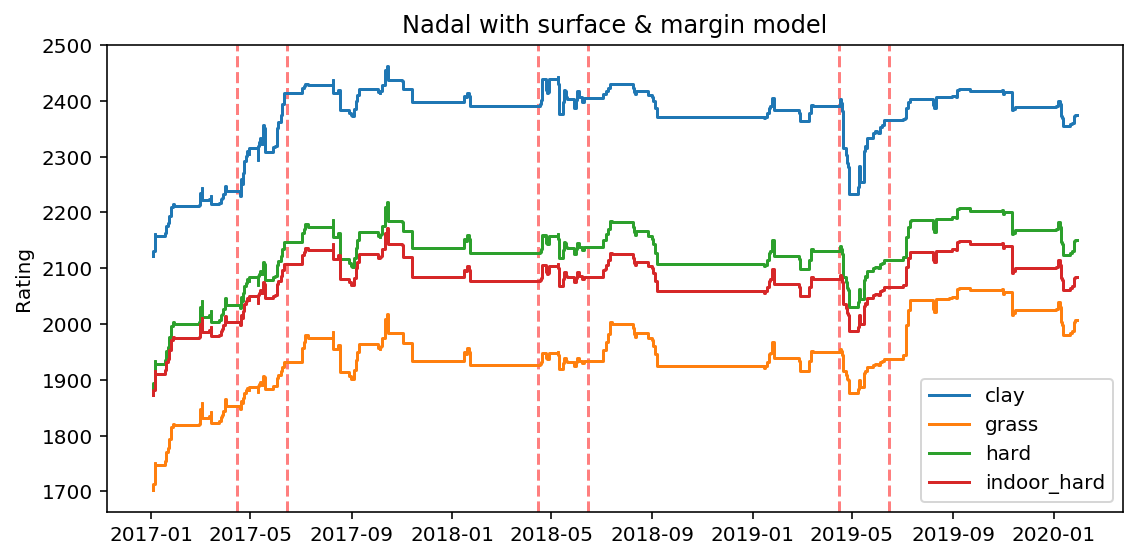

In [72]:
from datetime import datetime

f, ax = plt.subplots(1, 1)

to_plot = dates.dt.year >= 2017

for cur_year in range(2017, 2020):
    
    clay_start = datetime(cur_year, 4, 15)
    clay_end = datetime(cur_year, 6, 15)
    ax.axvline(clay_start, linestyle='--', color='r', alpha=0.5)
    ax.axvline(clay_end, linestyle='--', color='r', alpha=0.5)

for cur_skill, cur_surface in zip(player_skills.T, surf_encoder.classes_):

    ax.step(dates[to_plot], cur_skill[to_plot] + 1500, label=cur_surface)

f.set_size_inches(8, 4)
ax.legend()
plt.title('Nadal with surface & margin model')
ax.set_ylabel('Rating')
f.tight_layout()

plt.savefig('/Users/ingramm/Documents/uni_melb/progress_review/latex_version/nadal_improved.pdf')